# Pre-treatment

In [138]:
import os
import cv2
import csv
from matplotlib import pyplot as plt
from typing import Tuple, Generator
import numpy as np
from skimage import io, util, transform, color, feature, exposure
from skimage.feature import hog
import random
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
from joblib import Parallel, delayed
from matplotlib import patches
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from datetime import datetime
import uuid


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [60]:
# concatenate all csv files into one
with open('data/labels.csv', 'w') as outfile:
    for file in os.listdir('data/labels_csv'):
        with open('data/labels_csv/' + file) as infile:
            # add filename to each line
            for line in infile:
                outfile.write(file[:-4] + ',' + line)

In [127]:
def get_ecocup_info(difficult: bool) -> Generator[Tuple[str, int, int, int, int], None, None]:
    with open("data/labels.csv") as file:
        line = file.readline()
        while line:
            img_name, x, y, w, h, diff = map(str.strip, line.split(','))
            if not difficult and diff == '1':
                # skip difficult images
                pass
            elif int(w) / int(h) < 1.5 or int(w) / int(h) > 2:
                # skip images with wrong aspect ratio
                pass
            else:
                yield img_name, x, y, w, h
            line = file.readline()


# returns a cv2 image
def ecocup_image(image_file: str, x: int, y: int, w: int, h: int) -> np.ndarray:
    return io.imread('data/images/pos/' + image_file + '.jpg')[int(x):int(x) + int(w), int(y):int(y) + int(h)]


def get_pos_images(difficult=False) -> Generator[np.ndarray, None, None]:
    # generate positive images (ecocups)
    for info in get_ecocup_info(difficult):
        yield info, resize_image(ecocup_image(*info), (50, 100))


def resize_image(source: np.ndarray, size: Tuple[int, int]) -> np.ndarray:
    return cv2.resize(source, size)


def hog_image(image: np.ndarray) -> np.ndarray:
    # image to greyscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return hog(image, visualize=True)

def save_pos_images(save_dir: str = 'data/augmented_images', difficult: bool = False):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for i, (info, image) in enumerate(get_pos_images(difficult)):
        filename = f"{i:04}.jpg"
        filepath = os.path.join(save_dir, filename)
        io.imsave(filepath, util.img_as_ubyte(image))

def augment_pos_images(num_images: int = 10, save_dir: str = 'data/augmented_images', difficult: bool = False):
    random.seed(datetime.now())
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    i = len(os.listdir(save_dir))
    for info, image in get_pos_images(difficult):
        for j in range(num_images):
            # random flip
            if random.uniform(0,1) < 0.5:
                image = cv2.flip(image, 1)
            if random.uniform(0,1) < 0.9:
                augmented = image[
                random.randint(0, int(image.shape[0]/4)):
                random.randint(image.shape[0] - int(image.shape[0]/4), image.shape[0]),
                random.randint(0, int(image.shape[1]/4)):
                random.randint(image.shape[1] - int(image.shape[1]/4), image.shape[1])] # Slicing to crop the image
            # random contrast factor between 0.75 and 1.25
            contrast = random.uniform(0.85, 1.15)
            # random brightness shift between -25 and 25
            brightness = random.uniform(-20, 20)
            # random gamma correction factor between 0.75 and 1.25
            gamma = random.uniform(0.85, 1.15)
            # apply color changes
            augmented = cv2.convertScaleAbs(image, alpha=contrast, beta=brightness)
            augmented = np.power(augmented / 255.0, gamma)
            augmented = np.uint8(augmented * 255)
            # save augmented image
            filename = f"{i:04}.jpg"
            filepath = os.path.join(save_dir, filename)
            io.imsave(filepath, util.img_as_ubyte(augmented))
            i += 1

def generate_negative_images(num_images: int, save_dir: str = 'data/negative_images', source_dir: str = 'data/images/neg'):
    random.seed(datetime.now())
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    i = len(os.listdir(save_dir))
    for j in range(num_images):
        # choose a random source image
        source_file = random.choice(os.listdir(source_dir))
        source_image = io.imread(os.path.join(source_dir, source_file))
        # choose a random patch from the source image
        rand = random.randint(50,150)
        patch_size = (int(random.uniform(1.5, 2)*rand), rand)
        patch_x = random.randint(0, max(0,source_image.shape[0] - patch_size[0]))
        patch_y = random.randint(0, max(0,source_image.shape[1] - patch_size[1]))
        patch = source_image[patch_x:patch_x + patch_size[0], patch_y:patch_y + patch_size[1]]
        patch = transform.resize(patch, (200, 100))
        # save negative image
        filename = f"{i:04}.jpg"
        filepath = os.path.join(save_dir, filename)
        io.imsave(filepath, util.img_as_ubyte(patch))
        i += 1
        
def IoU(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # calculate intersection area
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)
    if x_right < x_left or y_bottom < y_top:
        intersection_area = 0
    else:
        intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # calculate union area
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area

    # calculate IoU
    if union_area == 0:
        iou = 0
    else:
        iou = intersection_area / union_area

    return iou

def train_svm_with_hog():
    # Load positive images
    print("loading pos img")
    pos_dir = 'data/augmented_images'
    pos_images = []
    for filename in os.listdir(pos_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(pos_dir, filename)
            image = io.imread(image_path)
            # resize the image to (100, 200)
            image = transform.resize(image, (100, 200))
            # compute HOG features for the image
            hog_features = feature.hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True)
            pos_images.append(hog_features)

    # Load negative images
    print("loading neg img")
    neg_dir = 'data/negative_images'
    neg_images = []
    for filename in os.listdir(neg_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(neg_dir, filename)
            image = io.imread(image_path)
            # resize the image to (100, 200)
            image = transform.resize(image, (100, 200))
            # compute HOG features for the image
            hog_features = feature.hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True)
            neg_images.append(hog_features)

    # Combine positive and negative images into a single dataset
    images = np.concatenate([pos_images, neg_images])
    labels = np.concatenate([np.ones(len(pos_images)), np.zeros(len(neg_images))])

    # split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
    print("train model")
    # train the SVM
    clf = svm.SVC(probability=True)
    clf.fit(X_train, y_train)

    # evaluate the model on the validation set
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation accuracy: {acc:.2f}")
    
    # save the trained model
    model_dir = 'data/svm_model7.joblib'
    joblib.dump(clf, model_dir)

    return clf

def train_svm_poly():
    # Load positive images
    pos_dir = 'data/augmented_images'
    pos_images = []
    for filename in os.listdir(pos_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(pos_dir, filename)
            image = io.imread(image_path)
            # resize the image to (100, 200)
            image = transform.resize(image, (100, 200))
            # compute HOG features for the image
            hog_features = feature.hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True)
            pos_images.append(hog_features)

    # Load negative images
    neg_dir = 'data/negative_images'
    neg_images = []
    for filename in os.listdir(neg_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(neg_dir, filename)
            image = io.imread(image_path)
            # resize the image to (100, 200)
            image = transform.resize(image, (100, 200))
            # compute HOG features for the image
            hog_features = feature.hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True)
            neg_images.append(hog_features)

    # Combine positive and negative images into a single dataset
    images = np.concatenate([pos_images, neg_images])
    labels = np.concatenate([np.ones(len(pos_images)), np.zeros(len(neg_images))])

    # split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
    print("train model")
    # train the SVM
    clf = svm.SVC(probability=True, kernel='poly', degree=5)
    clf.fit(X_train, y_train)

    # evaluate the model on the validation set
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation accuracy: {acc:.2f}")
    
    # save the trained model
    model_dir = 'data/svm_modelpoly.joblib'
    joblib.dump(clf, model_dir)

    return clf

def train_rf_with_hog():
    # Load positive images
    print("loading pos img")
    pos_dir = 'data/augmented_images'
    pos_images = []
    for filename in os.listdir(pos_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(pos_dir, filename)
            image = io.imread(image_path)
            # resize the image to (100, 200)
            image = transform.resize(image, (100, 200))
            # compute HOG features for the image
            hog_features = feature.hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True)
            pos_images.append(hog_features)

    # Load negative images
    print("loading neg img")
    neg_dir = 'data/negative_images'
    neg_images = []
    for filename in os.listdir(neg_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(neg_dir, filename)
            image = io.imread(image_path)
            # resize the image to (100, 200)
            image = transform.resize(image, (100, 200))
            # compute HOG features for the image
            hog_features = feature.hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True)
            neg_images.append(hog_features)

    # Combine positive and negative images into a single dataset
    images = np.concatenate([pos_images, neg_images])
    labels = np.concatenate([np.ones(len(pos_images)), np.zeros(len(neg_images))])

    # split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
    print("train model")
    # train the Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # evaluate the model on the validation set
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation accuracy: {acc:.2f}")
    
    # save the trained model
    model_dir = 'data/rf_model.joblib'
    joblib.dump(clf, model_dir)

    return clf

def train_adaboost_with_hog():
    # Load positive images
    print("loading pos img")
    pos_dir = 'data/augmented_images'
    pos_images = []
    for filename in os.listdir(pos_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(pos_dir, filename)
            image = io.imread(image_path)
            # resize the image to (100, 200)
            image = transform.resize(image, (100, 200))
            # compute HOG features for the image
            hog_features = feature.hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True)
            pos_images.append(hog_features)

    # Load negative images
    print("loading neg img")
    neg_dir = 'data/negative_images'
    neg_images = []
    for filename in os.listdir(neg_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(neg_dir, filename)
            image = io.imread(image_path)
            # resize the image to (100, 200)
            image = transform.resize(image, (100, 200))
            # compute HOG features for the image
            hog_features = feature.hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True)
            neg_images.append(hog_features)

    # Combine positive and negative images into a single dataset
    images = np.concatenate([pos_images, neg_images])
    labels = np.concatenate([np.ones(len(pos_images)), np.zeros(len(neg_images))])

    # split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
    print("train model")
    # train the AdaBoost classifier
    clf = AdaBoostClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # evaluate the model on the validation set
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation accuracy: {acc:.2f}")
    
    # save the trained model
    model_dir = 'data/adaboost_model.joblib'
    joblib.dump(clf, model_dir)

    return clf


def test_model_ss(clf, test_images_dir='data/test', save_dir='data/results', result_file='data/result.csv'):
    with open(result_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['n', 'i', 'j', 'h', 'l', 's'])  # header row
        for n, filename in enumerate(os.listdir(test_images_dir)):
            if not filename.endswith('.jpg'):
                continue
            print(n)
            image_path = os.path.join(test_images_dir, filename)
            image = cv2.imread(image_path)
            plt.imshow(image)
            # run selective search algorithm to generate object proposals
            ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            boxes = ss.process()
            sorted(boxes, key=lambda x: x[2]*x[3],reverse=True)
            
            non_overlapping_boxes = []
            for box in boxes:
                x, y, h, w = box
                if (int(w) * int(h) < 2000) or (int(w) / int(h) > 4.5) or ((int(h) / int(w) > 4.5)):
                        continue
                if (int(h) / int(w) < 1.5):
                    h = int(1.5 * w)
                if (int(h) / int(w) > 2):
                    w = int(h / 1.5)
                if (int(w) * int(h) < 2000):
                        continue
                proposal_img = image[y:y+h, x:x+w]
                # resize the image to (100, 200)
                proposal_img = cv2.resize(proposal_img, (100, 200))
                plt.imshow(proposal_img)
                # encode the image as HOG features
                hog_features = feature.hog(proposal_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True)
                # make a prediction using the SVM
                pred = clf.predict(hog_features.reshape(1, -1))
                if pred[0] > 0:
                    non_overlapping = True
                    for other_box in non_overlapping_boxes:
                        iou = IoU(box, other_box)
                        if iou > 0.25:
                            non_overlapping = False
                            break
                    if non_overlapping:
                        #print(pred)
                        non_overlapping_boxes.append(box)
            # write the non-overlapping boxes to the CSV file
            for box in non_overlapping_boxes:
                x, y, w, h = box
                score = 0.0  # set score to 0 for now
                writer.writerow([n, x, y, h, w, score])
            # draw the non-overlapping boxes on the image
            for box in non_overlapping_boxes:
                x, y, w, h = box
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
            # save the image with boxes drawn on it
            save_path = os.path.join(save_dir, filename)
            cv2.imwrite(save_path, image)
        plt.show()
        
        
def get_box_from_labels(image_name, labels_file='data/labels.csv'):
    """Returns the list of bounding boxes for the given image_name in the labels_file."""
    #print("file", image_name)
    with open(labels_file, 'r') as f:
        reader = csv.reader(f)
        #next(reader)  # skip header row
        boxes = []
        for row in reader:
            if row[0] == image_name:
                y, x, h, w, s = map(int, row[1:])
                boxes.append((x, y, w, h))
        return boxes

    
def test_model_sw(clf, test_images_dir='data/test', save_dir='data/results', result_file='data/result.csv', debug=False):
    with open(result_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        #writer.writerow(['n', 'i', 'j', 'h', 'l', 's'])  # header row
        filenames = os.listdir(test_images_dir)
        filenames.sort()
        random.seed(datetime.now())
        random.shuffle(filenames)
        

        for n, filename in enumerate(filenames):
            if not filename.endswith('.jpg'):
                continue
            print(filename)
            image_path = os.path.join(test_images_dir, filename)
            image = cv2.imread(image_path)
            plt.imshow(image)
            img_height, img_width = image.shape[:2]
            true_height, true_width = image.shape[:2]
            
            window_factor = 15
            window_size = (int(min(img_width,img_height)/window_factor),int(2 * min(img_width,img_height)/window_factor))
            window_size = (100, 200)
            boxes_found = []
            sizes = [70, 100]
            ratios = [1.5, 1.75, 2]

            for size in sizes:
                for ratio in ratios:
                    window_size = (int(size), int(size * ratio))
                    image = cv2.imread(image_path)
                    for n in range(8):
                        img_height, img_width = image.shape[:2]
                        w, h = window_size
                        for i in range(0, img_height - window_size[1], int(window_size[1]/3)):
                            for j in range(0, img_width - window_size[0], int(window_size[0]/3)):
                                x, y = j, i
                                proposal_img = image[y:y+h,x:x+w]
                                if proposal_img.shape != (h, w, 3):
                                    break
                                # resize the image to (100, 200)
                                proposal_img = cv2.resize(proposal_img, (100, 200))
                                # encode the image as HOG features
                                hog_features = feature.hog(proposal_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True)
                                # make a prediction using the SVM
                                proba = clf.predict_proba(hog_features.reshape(1, -1))
                                if proba[0][1] > 0.55:
                                    scale_x = true_width / img_width
                                    scale_y = true_height / img_height
                                    true_x = int(x * scale_x)
                                    true_y = int(y * scale_y)
                                    true_w = int(w * scale_x)
                                    true_h = int(h * scale_y)
                                    box = (true_x, true_y, true_w, true_h)
                                    boxes_found.append([box, proba[0][1]])

                        image = cv2.resize(image, (int(img_width*0.85), int(img_height*0.8)))
            image = cv2.imread(image_path)
            # sort boxes by probability
            boxes_found = sorted(boxes_found, key=lambda x: x[1], reverse=True)

            # loop through boxes and remove those with high IoU
            boxes_to_remove = []
            for i in range(len(boxes_found)):
                for j in range(i+1, len(boxes_found)):
                    iou = IoU(boxes_found[i][0], boxes_found[j][0])
                    if iou > 0.4:
                        boxes_to_remove.append(j)
            boxes_to_remove = list(set(boxes_to_remove))
            boxes_found = [box for i, box in enumerate(boxes_found) if i not in boxes_to_remove]

            # loop through remaining boxes and test against labels
            if debug:
                name, ext = os.path.splitext(filename)
                labels = get_box_from_labels(name)
                for box in boxes_found:
                    has_label = False
                    for label in labels:
                        iou = IoU(box[0], label)
                        if iou >= 0.3:
                            has_label = True
                            break
                    if not has_label:
                        #if random.uniform(0,1) < 0.5:
                        # Add image to negative training dataset
                        negative_img = image[box[0][1]:box[0][1]+box[0][3], box[0][0]:box[0][0]+box[0][2]]
                        negative_img = cv2.resize(negative_img, (100, 200))
                        cv2.imwrite(os.path.join('data/negative_images', f"false_positive_{str(uuid.uuid4())[:8]}.jpg"), negative_img)
                    else:
                        pos_img = image[box[0][1]:box[0][1]+box[0][3], box[0][0]:box[0][0]+box[0][2]]
                        pos_img = cv2.resize(pos_img, (100, 200))
                        cv2.imwrite(os.path.join('data/augmented_images', f"pos_{str(uuid.uuid4())[:8]}.jpg"), pos_img)


            # write the non-overlapping boxes to the CSV file
            for box in boxes_found:
                x, y, w, h = box[0]
                score = box[1]
                writer.writerow([n, y, x, h, w, score])
            # draw the non-overlapping boxes on the image
            for box in boxes_found:
                x, y, w, h = box[0]
                score = box[1]
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, int((score-0.55) * 255*45), 0), 2)
            # save the image with boxes drawn on it
            save_path = os.path.join(save_dir, filename)
            cv2.imwrite(save_path, image)


In [170]:
test_model_sw(clf, test_images_dir='data/images/pos/', debug=True)

linsongt_pos_002.jpg
haocharl_pos_002.jpg
quoysalo_pos_001.jpg
aleymari_pos_002.jpg
rfeghoul_pos_004.jpg
gasmiisl_pos_008.jpg
tmoricea_pos_004.jpg
quoysalo_pos_007.jpg
smejiava_pos_010.jpg
shaoxing_pos_001.jpg
adornipi_pos_008.jpg
nscheidl_pos_010.jpg
frogerro_pos_002.jpg


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7fd3bde2a280> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fd3b0df80d0> (for post_execute):


KeyboardInterrupt: 

In [83]:
save_pos_images()
#augment_pos_images(num_images=4)
#generate_negative_images(800)

In [169]:
clf = train_svm_with_hog()
#clf = train_svm_poly()
#clf = train_rf_with_hog()
#clf = train_adaboost_with_hog()

loading pos img
loading neg img
train model
Validation accuracy: 0.93


In [89]:
#clf = joblib.load('data/svm_model2.joblib')
#clf = joblib.load('data/svm_modelpoly.joblib')
#clf = joblib.load('data/rf_model.joblib')

KeyError: 0

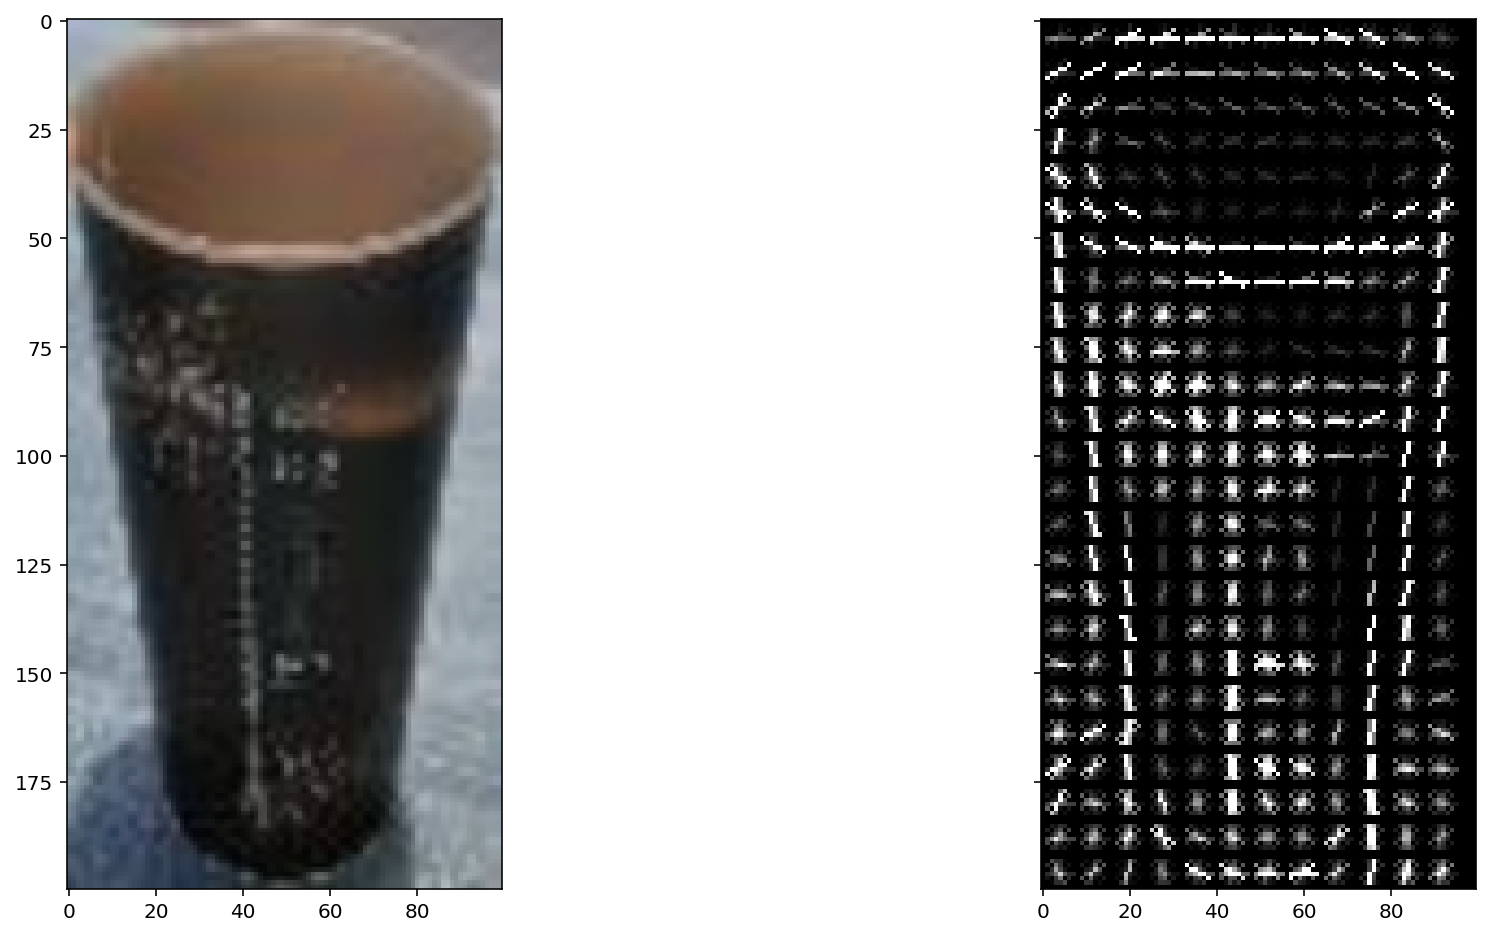

In [168]:
proposal_img = cv2.imread('data/augmented_images/0025.jpg')
proposal_img = cv2.resize(proposal_img, (100, 200))

fd, hog_features = hog(proposal_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)

hog_image_rescaled = exposure.rescale_intensity(hog_features, in_range=(0, 10)) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
ax1.imshow(proposal_img)
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
#pred = clf.predict_proba(hog_features.reshape(1, -1))
#print(pred)

024.jpg
053.jpg
112.jpg
001.jpg
090.jpg
050.jpg
098.jpg
081.jpg
104.jpg
061.jpg
040.jpg
118.jpg
007.jpg
120.jpg
043.jpg
088.jpg


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7fd3bde2a280> (for post_execute):


KeyboardInterrupt: 

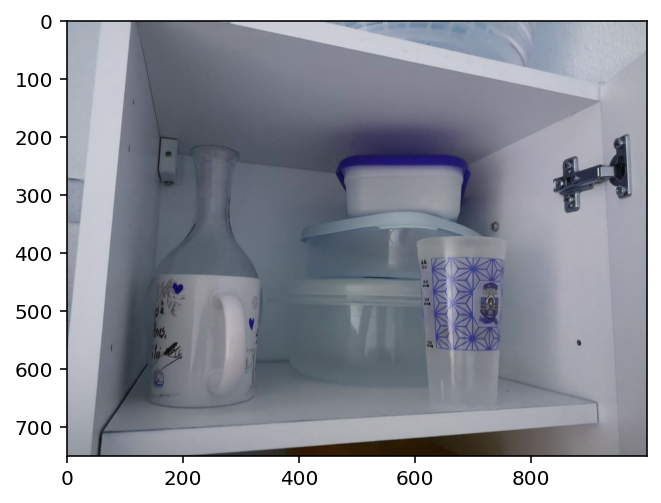

In [123]:
test_model_sw(clf, test_images_dir='data/test_old/', debug=False)